# Predicting prices for Airbnb rentals

<p style="text-align: justify">Platforms to connect landlords and tentants for temporary housing have become a cheap and good alternative to traditional hotel bookings in the tourism industry.</p>
<p style="text-align: justify">Airbnb's business model relies mainly on a fee charged from the total rental price, so it's in their best interest to optimize the prices in order to maximize their revenue. From the point of view of guests, it is benefitial to them to have fair prices that reflect the market and the value of properties. Likewise, hosts don't want to undercharge for the property nor overcharge, because it can reduce the demand.</p>
<p style="text-align: justify">Thus, the question I'm trying to answer is: <b>Can we predict rental prices from features related to the property ?</b></p>

## Loading the data

In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split
import missingno as msno
from datetime import datetime as dt

In [2]:
df = pd.read_csv("./data/train.csv")

In [3]:
df.shape

(74111, 29)

In [4]:
df.columns

Index(['id', 'log_price', 'property_type', 'room_type', 'amenities',
       'accommodates', 'bathrooms', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'city', 'description', 'first_review',
       'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
       'host_since', 'instant_bookable', 'last_review', 'latitude',
       'longitude', 'name', 'neighbourhood', 'number_of_reviews',
       'review_scores_rating', 'thumbnail_url', 'zipcode', 'bedrooms', 'beds'],
      dtype='object')

Here, we have a dataset of 74,111 rows and 28 features related to the property, such as location, reviews and rooms. The target variable is the log of the price.

The first thing to do is to separate the target variable from the features. The target column is *log_price*, while all the other columns will be part of the feature dataset, except for the id, which I'll drop now as it is not relevant to the problem (it is a unique number for each row).

In [8]:
X_raw = df.iloc[:,2:]
y = df["log_price"]

## Cleaning the data

Before we start fitting models into the data, it is useful to explore the dataset to detect anomalies, handle missing values and preprocess some features.

Let's now see a sample of the first 5 rows of the feature set and a brief description of the main statistics:

In [11]:
# pd.set_option("display.max_columns", None)
X_raw.head()

,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,t,t,NaN,2012-03-26,f,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,2017-08-05,t,f,100%,2017-06-19,t,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,The Oasis comes complete with a full backyard ...,2017-04-30,t,t,100%,2016-10-25,t,2017-09-14,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,This light-filled home-away-from-home is super...,NaN,t,t,NaN,2015-04-19,f,NaN,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,"Cool, cozy, and comfortable studio located in ...",2015-05-12,t,t,100%,2015-03-01,t,2017-01-22,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


We can see some missing values in the data. Let's dive deep into this problem.

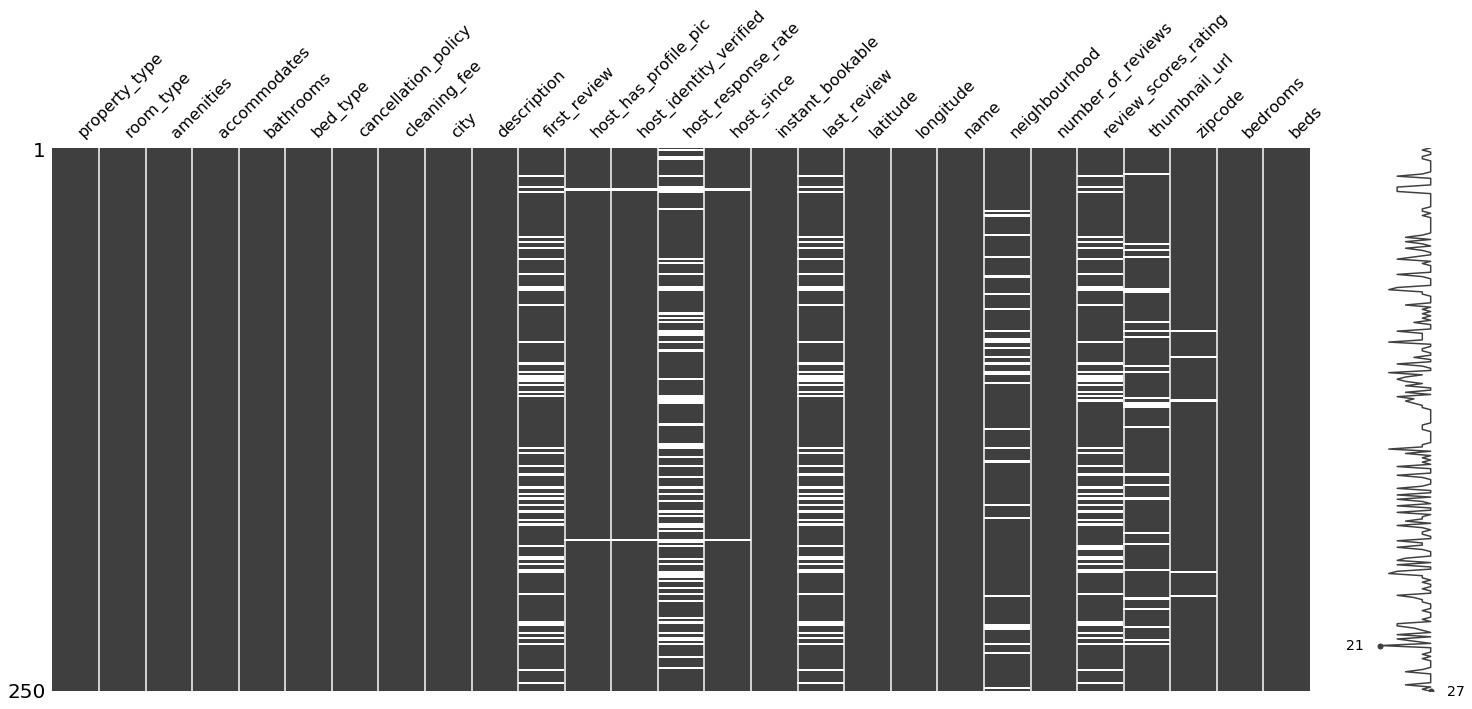

In [12]:
msno.matrix(X_raw.sample(250))

<p style="text-align: justify">Some columns have a lot of missing values, so it is not reasonable to remove all those rows from the dataset. Also, by dropping those columns we would lose valuable information to the models. Therefore, the approach I'm going to use is to replace the missing values by the string 'NA' if the variable is categorical, or by 0 if the variable is numerical. Besides replacing by 0 in the numerical case, I'll add boolean features that indicate if the row had a missing value or not. After that, for the columns with few missing values, such as <i>bathrooms</i>, <i>zipcode</i> and <i>beds</i>, I'm just going to drop those rows. Finally, I will also drop the column <i>thumbnail_url</i>, as it doesn't provide useful information, the columns <i>zipcode</i>, as the latitude and longitude already provide a geolocation feature and the text variables <i>description</i> and <i>name</i> in order to simplify the problem and avoid NLP techniques that will increase too much the number of features.</p>

In [92]:
X = X_raw.drop(columns=["thumbnail_url", "description", "name", "zipcode"])
X[["first_review_NA", "host_response_rate_NA", "last_review_NA", "review_scores_rating_NA"]] = X_raw[["first_review", "host_response_rate", "last_review", "review_scores_rating"]].fillna("NA").apply(lambda col: col.apply(lambda x: 1 if x=="NA" else 0))
X[["first_review", "last_review", "review_scores_rating"]] = X_raw[["first_review", "last_review", "review_scores_rating"]].fillna(0)
X.neighbourhood = X_raw.neighbourhood.fillna("NA")
X.host_response_rate = X_raw.host_response_rate.fillna("0%")
print(X.shape[0])
X.dropna(inplace=True)
print(X.shape[0])

74111
73579


By replacing missing values by 0, I'm treating true 0 the same as missing values. This may break the linearity of the model for the linear regression, so that's why I chose to add boolean features too. By removing the missing values, our feature dataset has now around 2,000 less rows.

Now, we need to convert some data types that are not the most appropriate for ML training. I'll convert date strings into number of days until a reference date, I'll convert the <i>amenities</i> column into number of amenities, I'll convert all boolean variables to 0 and 1 and <i>host_response_rate</i> to numeric.

In [93]:
try:
    today = dt.today()
    X.amenities = X.amenities.str.split(",").apply(len)
    X[["first_review", "last_review"]] = X[["first_review", "last_review"]].apply(lambda col: col.apply(lambda x: (today-dt.fromisoformat(x)).days if x!=0 else x))
    X.host_response_rate = X.host_response_rate.str.replace("%", "").astype(int)
    X[["host_has_profile_pic", "host_identity_verified", "instant_bookable"]] = X[["host_has_profile_pic", "host_identity_verified", "instant_bookable"]].apply(lambda col: col.apply(lambda x: 1 if x == "t" else 0))
    X.cleaning_fee = X.cleaning_fee.apply(lambda x: 1 if x==True else 0)
except:
    pass

Let's now explore the data a little more:

In [94]:
X.describe()

,amenities,accommodates,bathrooms,cleaning_fee,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,last_review,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds,first_review_NA,host_response_rate_NA,last_review_NA,review_scores_rating_NA
count,73579.000000,73579.000000,73579.000000,73579.000000,73579.000000,73579.000000,73579.000000,73579.000000,73579.000000,73579.000000,73579.000000,73579.000000,73579.000000,73579.000000,73579.000000,73579.000000,73579.000000,73579.000000,73579.000000,73579.000000
mean,17.635331,3.160888,1.236039,0.734884,1244.040963,0.996956,0.673263,71.252708,0.263023,912.591514,38.441312,-92.441681,20.889425,72.865437,1.266802,1.712975,0.213920,0.244920,0.213498,0.225472
std,6.923991,2.156297,0.582947,0.441398,781.401863,0.055092,0.469023,42.988835,0.440278,517.130914,3.081897,21.711043,37.818332,39.913863,0.853585,1.256094,0.410074,0.430043,0.409779,0.417896
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.338905,-122.511500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.000000,2.000000,1.000000,0.000000,1011.000000,1.000000,0.000000,0.000000,0.000000,964.000000,34.126898,-118.342867,1.000000,80.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,17.000000,2.000000,1.000000,1.000000,1341.000000,1.000000,1.000000,100.000000,0.000000,1031.000000,40.661481,-76.998494,6.000000,94.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,22.000000,4.000000,1.000000,1.000000,1701.000000,1.000000,1.000000,100.000000,1.000000,1152.000000,40.746124,-73.954688,23.000000,99.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000
max,86.000000,16.000000,8.000000,1.000000,4201.000000,1.000000,1.000000,100.000000,1.000000,4136.000000,42.390437,-70.985047,605.000000,100.000000,10.000000,18.000000,1.000000,1.000000,1.000000,1.000000


There doesn't seem to be any anomalous value for the numeric features. Now, the last thing to do is to convert all categorical variables into one-hot encoding format.

In [98]:
# Coming soon

In order to train and evaluate different machine learning models, this dataset must also be split into a training and test datasets. Here, I'm going to use a 80/20 split.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Baseline model

<p style="text-align: justify">The baseline model for a regression problem is to simply predict without the additional information brought by the features, that is, using only the target variable. The best predictor, which minimizes the RMSE, is the average of the distribution of the target variable, and thus will be used as baseline of comparison with other models.</p>
<p style="text-align: justify">In fact, if we use the R² as the evaluation metric, this baseline is already incorporated in the formula, so all the performances will be measured relative to this baseline.</p>

In [97]:
y.mean()

4.782069108304868

For this problem, the baseline model is to always predict 4.78 as the log of the price.

## First model: Linear Regression

COMING SOON ...

## Second model: Decision Tree

COMING SOON ...

## Third model: Random Forest

COMING SOON ...

## Conclusion

COMING SOON ...